In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
from dataset import CANDataset
from losses import SupConLoss, UniConLoss
from networks.resnet_big import ConResNet
from networks.resnet_big import CEResNet
from networks.resnet_big import LinearClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from util import accuracy
from networks.resnet_big import LinearClassifier
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import random
from sklearn.manifold import TSNE

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Utils Functions

In [4]:
def get_test_features(test_loader, model):
    model.eval()
    # torch.cuda.empty_cache()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
            features = model.encoder(images)  # Assuming the model has an encoder
            all_features.append(features)
            all_labels.append(labels)
    return all_features, all_labels

In [5]:
def change_new_state_dict(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [6]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (8 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [7]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [8]:
def set_classifier(features, labels, classifier, class_opt):
    # class_opt = optim.SGD(classifier.parameters(),
    #                       lr=0.05,
    #                       momentum=0.9,
    #                       weight_decay=1e-4)

    # Train the classifier
    classifier.train()
    for i in range(50):
        for j in range(len(features)):
            feature = features[j]
            y = labels[j]
            y_pred = classifier(feature)
            loss = F.cross_entropy(y_pred, y)
            class_opt.zero_grad()
            loss.backward()
            class_opt.step()
    return classifier

In [9]:
def load_model(model, checkpoint_path):
    print(f"Loading model from {checkpoint_path}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    # ckpt = torch.load(checkpoint_path)

    # Load state_dict from the checkpoint
    state_dict = ckpt['model']

    # Change state_dict if necessary (based on your existing function)
    state_dict = change_new_state_dict(state_dict)

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
    
    model.eval()  # Set the model to evaluation mode
    return model

## Test dataset loader

In [14]:
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = CANDataset(root_dir='../data/Car-Hacking/all_features/TFRecord_w32_s32/2', window_size=32, is_train=False, include_data=False, transform=can_transform)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    """
    Calculate confusion matrix, recall, precision, F1 score, and FNR for each class.

    Args:
    - label: True labels (NumPy array).
    - pred: Predicted labels (NumPy array).
    
    Returns:
    - Confusion matrix and a dictionary containing FNR, recall, precision, and F1 score.
    """
    # Compute confusion matrix
    cm = confusion_matrix(label, pred)
    
    # Recall: TP / (TP + FN)
    with np.errstate(divide='ignore', invalid='ignore'):
        recall = np.diag(cm) / np.sum(cm, axis=1)
        recall = np.nan_to_num(recall)  # Convert NaNs to 0
    
    # Precision: TP / (TP + FP)
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(cm) / np.sum(cm, axis=0)
        precision = np.nan_to_num(precision)  # Convert NaNs to 0
    
    # F1 score: 2 * (Precision * Recall) / (Precision + Recall)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1 = 2 * (precision * recall) / (precision + recall)
        f1 = np.nan_to_num(f1)  # Convert NaNs to 0

    # False Negative Rate (FNR): (FN / Actual Total) * 100
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    with np.errstate(divide='ignore', invalid='ignore'):
        fnr = (total_actual - true_predicted) * 100 / total_actual
        fnr = np.nan_to_num(fnr)  # Convert NaNs to 0

    # Return confusion matrix and metrics
    return cm, {
        'fnr': fnr,
        'rec': recall,
        'pre': precision,
        'f1': f1
    }



## Load model architecture

In [26]:
# Load model architecture
model = ConResNet('resnet50')

checkpoint_path = "../save/CAN_models/UniCon/UniCon_CAN_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.1_mixup_lambda_0.5_trial_can_101324_151621_cosine_warm/ckpt_epoch_5.pth"

model = load_model(model, checkpoint_path)

Loading model from ../save/CAN_models/UniCon/UniCon_CAN_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.1_mixup_lambda_0.5_trial_can_101324_151621_cosine_warm/ckpt_epoch_5.pth


In [27]:
classifier = LinearClassifier(name='resnet50', num_classes=5).cuda()

class_opt = optim.SGD(classifier.parameters(),
                      lr=0.05,
                      momentum=0.9,
                      weight_decay=1e-4)
test_features, test_labels = get_test_features(test_loader, model)

# Load or set classifier (if not part of the model)
classifier = set_classifier(test_features, test_labels, classifier, class_opt)

In [28]:
classes = ['Normal', 'DoS', 'Fuzzy', 'Gear Spoof', 'RPM Spoof']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# classes = ['Normal', 'max_engine_coolant_temp', 'fuzzing', 'max_speedometer',
#              'reverse_light_on', 'reverse_light_off', 'correlated_signal']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
n_classes = len(classes)


In [142]:

# embeddings = []
# y = []
# y_pred = []

# classifier.eval()
# with torch.no_grad():
#     for i in range(len(test_features)):
#         feature = test_features[i]
#         label = test_labels[i]
        
#         # Store the original embeddings (the features before classifier)
#         embeddings.append(feature.cpu().numpy())  
        
#         # Perform classification
#         pred = classifier(feature)
        
#         y.append(label.cpu().numpy())  # Store true labels
#         y_pred.append(torch.argmax(pred, dim=1).cpu().numpy())  # Store predicted labels

# # Convert to numpy arrays
# embeddings = np.concatenate(embeddings)
# y_true = np.concatenate(y)
# y_pred = np.concatenate(y_pred)

# cm, metrics = cal_metric(y_true, y_pred)
# print_metrics_horizontal(metrics, classes)

In [29]:
classifier.eval()

embeddings = []
y_true = torch.tensor([]).cuda()  # True label
y_pred = torch.tensor([]).cuda()  # Predict label

with torch.no_grad():
        for i in range(len(test_features)):
            feature = test_features[i].cuda()
            label = test_labels[i].cuda()
        
            embeddings.append(feature.cpu().numpy())  

            pred = classifier(feature)
            
            y_true = torch.cat([y_true, label], dim=0)
            y_pred = torch.cat([y_pred, pred], dim=0)

y_pred_class = torch.argmax(y_pred, dim=1)

y_true = y_true.cpu().numpy()
y_pred = y_pred_class.cpu().numpy()

embeddings = np.concatenate(embeddings)

cm, metrics = cal_metric(y_true, y_pred)
print_metrics_horizontal(metrics, classes)


Metric | Normal       | DoS          | Fuzzy        | Gear Spoof   | RPM Spoof   
------------------------------------------------------------------------------
FNR    | 0.0615       | 23.0716      | 43.2490      | 0.1802       | 0.2112      
REC    | 0.9994       | 0.7693       | 0.5675       | 0.9982       | 0.9979      
PRE    | 0.9265       | 1.0000       | 1.0000       | 0.9964       | 0.9975      
F1     | 0.9616       | 0.8696       | 0.7241       | 0.9973       | 0.9977      


In [30]:
print(cm)

[[95823     0     0    52     7]
 [ 2351  7839     0     0     0]
 [ 5180     0  6868    12    42]
 [   32     0     0 17727     0]
 [   41     0     0     0 19369]]


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300)
    plt.show()

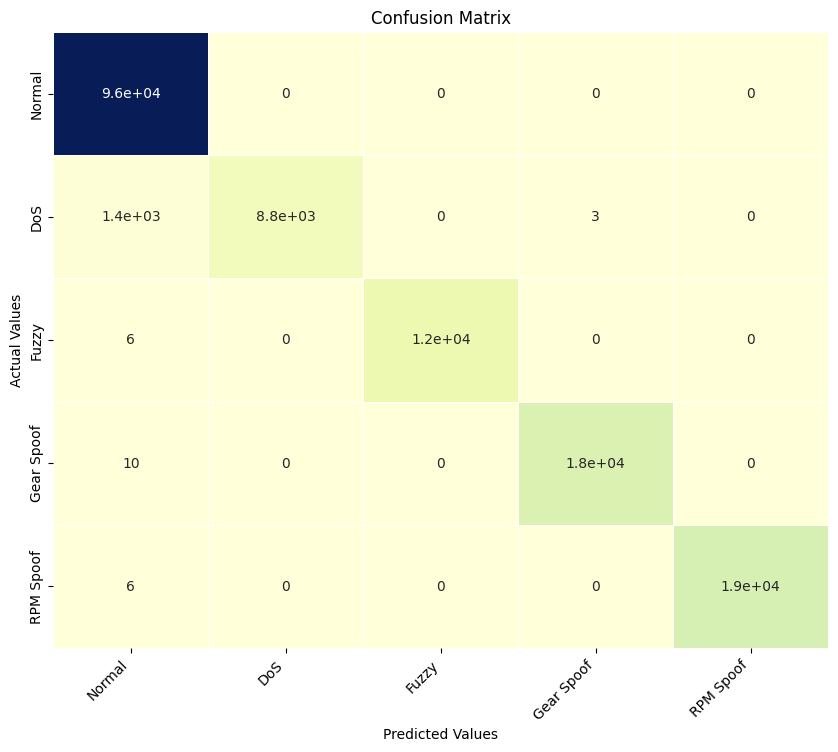

In [20]:
# fix_cm = np.array([[26595, 8, 1, 1, 1, 1, 1],
#                    [28, 12, 0, 0, 0, 0, 0],
#                    [26, 0, 18, 0, 0, 0, 0],
#                    [1, 0, 0, 8014, 0, 0, 0],
#                    [3, 0, 0, 0, 5582, 0, 0],
#                    [1, 0, 0, 0, 0, 3678, 0],
#                    [3, 0, 0, 0, 0, 0, 3676]])
draw_confusion_matrix(cm, classes, save_dir='../pic/tsne/confusion_matrix_unicon_road_v2.png')

In [182]:
np.random.seed(100)
indices = np.empty(shape=(0), dtype=int)
num_samples = 1000  # Adjust this value if needed

for c in range(n_classes):
    idx_c = np.where(y_true == c)[0]
    idx_c = np.random.choice(idx_c, num_samples, replace=True)
    indices = np.concatenate((indices, idx_c), axis=0)


In [148]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi đưa vào t-SNE
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [149]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=40)
reduced_embeddings = tsne.fit_transform(embeddings_scaled)
# reduced_embeddings = tsne.fit_transform(embeddings)

KeyboardInterrupt: 

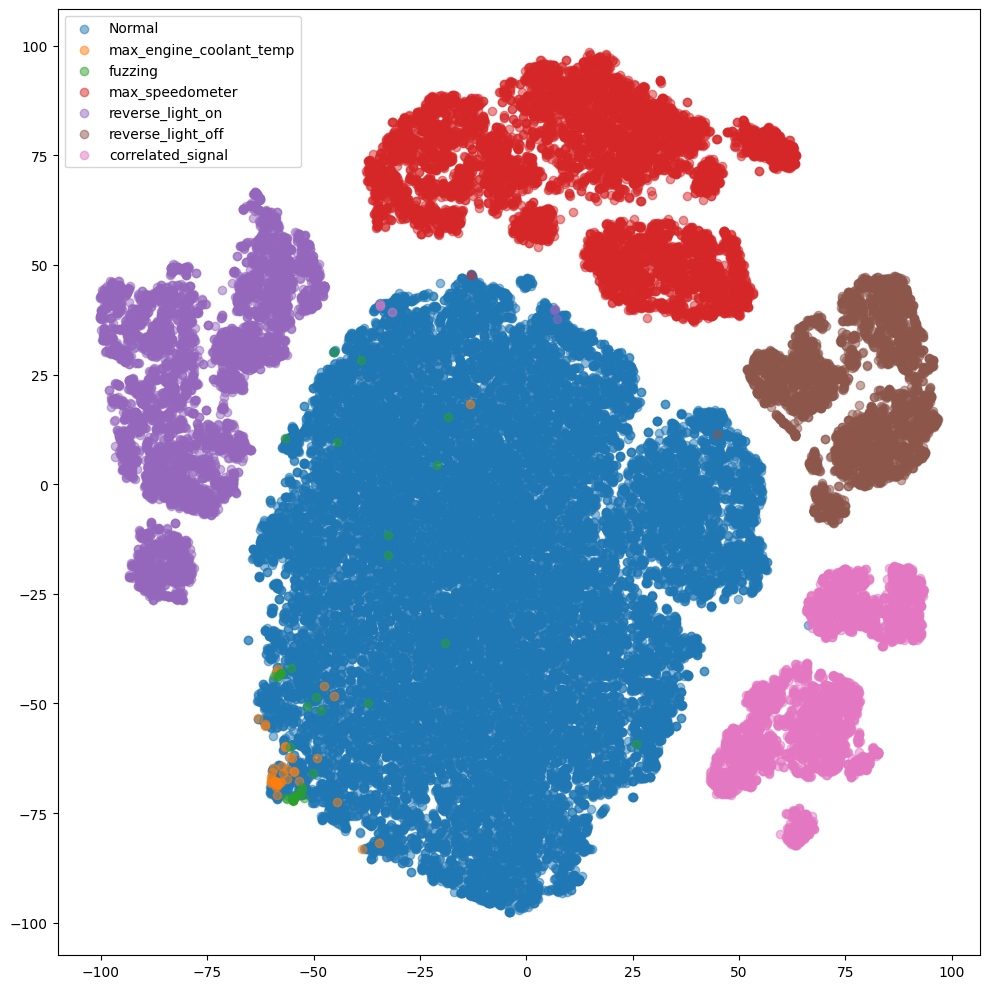

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(n_classes):
    inds = np.where(y_true == i)[0]  # Find indices for the current class
    plt.scatter(reduced_embeddings[inds, 0], reduced_embeddings[inds, 1], 
                alpha=0.5, color=colors[i], label=classes[i])

# Add title, labels, and legend
# plt.title('2D Embedding Visualization (Colored by True Labels)')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()
# plt.savefig('../pic/tsne/tsne_graph_unicon_road_2.png', dpi=300)